[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nmickevicius/mcwBiophysicsMriCourse/blob/main/phaseAndFrequencyEncoding.ipynb)

In [53]:
%matplotlib inline
import numpy as np
import scipy
import math
from ipywidgets import interact, interactive, FloatSlider, IntSlider, Checkbox
from IPython.display import clear_output, display, HTML

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 16

# Using Gradients to Locally Change Frequency

Starting with the Larmor equation:
$\omega = \gamma B$

With the gradient coils built into the scanner, we have the ability to change the magnetic field strength linearly as a function of the $x$, $y$, or $z$ axes.

The Larmor equation then describes a spatially dependent frequency as:
$\omega (y) = \gamma G y$.


In [23]:
def plotGrad(G, gammaBar):

    yvec = np.linspace(-0.12, 0.12, 100)
    f = gammaBar * G * 1e-3 * yvec * 1e-3
    fmax = yvec[-1] * 0.04 * 42.58e06 * 1e-3

    plt.figure()
    plt.plot(yvec, f)
    plt.xlabel('$y$ Position [m]')
    plt.ylabel('$f$ Larmor Frequency [kHz]')
    plt.ylim([-fmax, fmax])
    plt.grid()
    plt.show()

w = interactive(plotGrad,
                G=FloatSlider(min=-40.0, max=40.0, value=0.0, description='G [mT/m]', continuous_update=False),
                gammaBar=FloatSlider(min=10e6, max=42.58e6, value=42.58e6, description='gamma [Hz/T]', continuous_update=False))
display(w)




interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='G [mT/m]', max=40.0, min=-4…

# Spin Phase

Spins tipped into the transverse plane by an RF pulse precess around the applied magnetic field.

In [24]:
def plotPhaseUnitCircle(T):

    nspins = 16
    f = np.linspace(0.0, 100.0, nspins) # Hz
    om = 2 * np.pi * f                  # Rad/s
    phi = om * T * 1e-3                 # Rad

    print(f.shape)

    # spins start aligned along x axis
    xy = np.zeros((2,nspins), dtype=np.float32)
    xy[0,:] = 1.0

    R = np.zeros((2,2), dtype=np.float32)

    plt.figure()

    for s in range(nspins):

        R[0,0] = np.cos(phi[s])
        R[0,1] = -np.sin(phi[s])
        R[1,0] = np.sin(phi[s])
        R[1,1] = np.cos(phi[s])

        xyrot = R@xy[:,s]

        plt.arrow(0.0, 0.0, xyrot[0], xyrot[1])

    plt.xlim([-1,1])
    plt.ylim([-1,1])
    plt.grid()

    plt.show()

w = interactive(plotPhaseUnitCircle,
                T=FloatSlider(min=0.0, max=10.0, value=0.0, description='T [ms]', continuous_update=False))
display(w)


interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='T [ms]', max=10.0), Output(…

# Using Gradient ***PULSES*** to Locally Vary ***PHASE***

Keeping a (constant amplitude) gradient on for a fixed period of time will introduce a spatially dependent phase: $\phi (y) = \gamma G y T$

Here we will apply a gradient pulse and change its strength and duration to see the phase accrued as a function of position along the gradient axis.

In [25]:
def plotGradPulse(G, T):

    gammaBar = 42.58e06
    tvec = np.linspace(0.0, 1.0, 100)
    gwav = G*np.ones((tvec.size,))
    gwav[tvec >= T] = 0.0
    gwav[0] = 0.0
    gwav[-1] = 0.0

    yvec = np.linspace(-0.12, 0.12, 512)
    f = gammaBar * G * 1e-3 * yvec
    ph = f * T * 1e-3

    plt.figure(figsize=(8,4))

    # Plot Gx
    plt.subplot(121)
    plt.plot(tvec, gwav)
    plt.ylabel('$G$ [mT/m]')
    plt.xlabel('$Time$ [ms]')
    plt.ylim([-20, 50])
    plt.grid()

    plt.subplot(122)
    plt.plot(yvec, np.sin(ph))
    plt.xlabel('$y$ [m]')
    plt.ylabel('$sin(\phi)$')
    plt.ylim([-1.5, 1.5])
    plt.grid()

    plt.show()

w = interactive(plotGradPulse,
                G=FloatSlider(min=0.0, max=40.0, value=20.0, description='G [mT/m]', continuous_update=False),
                T=FloatSlider(min=0.0, max=1.0, value=0.5, description='T [ms]', continuous_update=False))
display(w)

interactive(children=(FloatSlider(value=20.0, continuous_update=False, description='G [mT/m]', max=40.0), Floa…

# Phase Encoding

From the section above, you can see that changing the ***area*** under the gradient pulse changes the number of phase cycles across the $y$ dimension. We refer to the range of $y$ values of interest as the "field-of-view".

In imaging, we choose the area under the pulse strategically to introduce a specific number of phase cycles across the FOV. This is done as follows:



In [26]:
gammaBar = 42.58e06
gamma = 2 * np.pi * gammaBar
fov = 0.24
ny = 32

delta_y = fov / ny
delta_k = 1 / fov
yv = np.arange(-ny/2, ny/2) * delta_y
kv = np.arange(-ny/2, ny/2) * delta_k

# define an array of desired number of phase cycles across imaging field of view
numCyclesAcrossFov = np.arange(-ny/2, ny/2)

# convert the cycles to phase
phaseAcrossFov = 2 * np.pi * numCyclesAcrossFov

# calculate the amplitude of a gradient pulse needed to achieve these phases
T = 0.0008 # hard-coded duration of pulse
G = phaseAcrossFov / ( gamma * fov * T)

# gradient waves for plotting purposes
tv = np.linspace(-T,T,100)
gwav = np.ones_like(tv)
gwav[np.abs(tv) > T/2] = 0.0
gwav = gwav[:,None] * G[None,:]

yvplot = np.linspace(-fov/2, fov/2, 1024)
f = gammaBar * G[None,:] * yvplot[:,None]
ph = 2 * np.pi * f * T

def plotPhaseEncodingConcept(IDX):

    plt.figure(figsize=(8,4))

    plt.subplot(121)
    plt.plot(gwav,color='k')
    plt.plot(gwav[:,IDX])

    plt.subplot(122)
    plt.plot(yvplot, np.sin(ph[:,IDX]))
    plt.xlabel('$y$ [m]')
    plt.ylabel('$sin(\phi)$')
    plt.grid()

    plt.show()

w = interactive(plotPhaseEncodingConcept,
                IDX=IntSlider(min=0, max=ny-1, value=ny/2, description='Index', continuous_update=False))
display(w)


interactive(children=(IntSlider(value=16, continuous_update=False, description='Index', max=31), Output()), _d…

# Building a Fourier Relationship

All spins precessing in the transverse plane will contribute to the voltage induced in the RF coils. This signal, demodulated at $\omega_0 = \gamma B_0$, is given by the following, where m(y) is the underlying image we are trying to measure.

$S = \int m(y) e^{i y \gamma G T} dy$

If we make the substitution $k = \frac{\gamma}{2 \pi} G T$, the signal equation becomes

$S(k) = \int m(y) e^{i 2 \pi y k} dy$

which is the equation for the Fourier transform: $S(k) = F\{ m(y)\}$

Since we measure discretized images, a more useful formalism of this relationship is as follows:

$S(n \Delta k) = \int m(y) e^{i 2 \pi y n \Delta k} dy$, where $n \in [-N/2, N/2-1]$ and $N$ is the imaging matrix size.



# One Dimensional Phase Encoding Pulse Sequence and Simulation

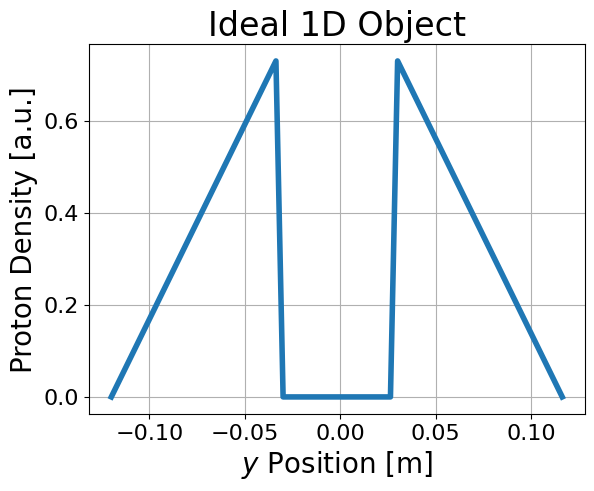

interactive(children=(IntSlider(value=1, continuous_update=False, description='Index', max=64, min=1), Output(…

In [27]:
# make the pulse sequence
gammaBar = 42.58e06
dt = 10e-6

# create ideal 1D object that we will be imaging
ny = 64
fov = 0.24
dy = fov/ny
yv = np.arange(-fov/2, fov/2, dy)
obj = 1-np.abs(np.linspace(-1, 1, ny, dtype=np.float32))
obj[np.abs(yv) < fov/8] = 0.0
plt.figure()
plt.plot(yv, obj)
plt.grid()
plt.title('Ideal 1D Object')
plt.ylabel('Proton Density [a.u.]')
plt.xlabel('$y$ Position [m]')
plt.show()
print('\n')

# phase encoding gradients
tgrad = 1e-3
ngrad = int(tgrad/dt)
dk = 1/fov
kv = np.arange(-ny/2, ny/2) * dk
G = kv / (gammaBar * tgrad)
gwav = np.zeros((ngrad+2,G.size), dtype=np.float32)
for n in range(G.size):
    gwav[1:-1,n] = G[n]

# non-selective RF pulse
flipAngle = 90
trf = 0.5e-3
nrf = int(trf/dt)
rfAmpl = flipAngle * np.pi / 180.0 / (2 * np.pi * gammaBar * trf) * 1e6 # micro Tesla
rfwav = np.zeros((nrf+2,), dtype=np.float32)
rfwav[1:-1] = rfAmpl

# for plotting pulse sequence
pad = np.zeros((int(ngrad/2),))
padg = np.zeros((int(ngrad/2),G.size))
rf = np.concatenate([rfwav, np.zeros((ngrad+2,)), pad],0)
grad = np.concatenate([np.zeros((nrf,G.size)), gwav, padg],0)

# simulate k-space
Sk = np.zeros((ny,), dtype=np.complex64)
for n in range(ny):
    Sk[n] = np.sum(obj * np.exp(-1j * 2 * np.pi * kv[n] * yv))

# center-out ordering
inds = np.arange(-ny/2, ny/2)
tmp = np.argsort(np.abs(inds))
lines = inds[tmp]
indices = (lines + ny/2).astype(np.int32)


def plotSim1d(IMAX):

    colors = plt.cm.viridis(np.linspace(0,1,ny))

    plt.figure()
    # plt.title('Pulse Sequence - Phase Encoding')

    plt.subplot(241)
    plt.plot(rf,color='k')
    plt.ylabel('RF [$\mu$T]')
    plt.grid()

    plt.subplot(245)
    for n in range(IMAX):
        plt.plot(1e3*grad[:,indices[n]],color=colors[n],linewidth=1.0)
    plt.ylim([-np.max(G)*1.1e3, np.max(G)*1.1e3])
    plt.ylabel('$G_y$ [mT/m]')
    plt.xlabel('Time')

    plt.subplot(222)
    sig = np.zeros((ny,), dtype=np.complex64)
    for n in range(IMAX):
        plt.scatter(kv[indices[n]], np.abs(Sk[indices[n]]), color=colors[n])
        sig[indices[n]] = Sk[indices[n]]
    plt.ylim([-0.1*np.max(np.abs(Sk)), 1.1*np.max(np.abs(Sk))])
    plt.xlim([np.min(kv), np.max(kv)])
    plt.xlabel('k-Space [1/m]')
    plt.ylabel('$|S(k)|$ [a.u.]')
    plt.grid()

    # reconstruct with inverse FFT
    rec = np.abs(np.fft.ifftshift(np.fft.ifft(np.fft.ifftshift(sig))))
    plt.subplot(224)
    plt.plot(rec)
    plt.grid()
    plt.ylabel('Reconstruction')
    plt.ylim([0.0, 1.1*np.max(np.abs(obj))])


    plt.show()

w = interactive(plotSim1d,
                IMAX=IntSlider(min=1, max=ny, value=1, description='Index', continuous_update=False))
display(w)


# Phase Encoding Summary

By applying a gradient pulse after RF excitation, you can control the amount of phase accrued as a linear function of position along the gradient axis. The signal induced in the coil is the inverse of Fourier transform of the object being imaged if the signal is sampled at equi-spaced $k$-space offsets. These offsets are calculated as to introduce a specific number of phase cycles over the field-of-view.

This is a highly effective method for imaging, but it is very slow! It requires a separate RF excitation for each sample. Fully phase encoded imaging in 1D is feasible, but scan time will increase exponentially for 2D and 3D imaging.

Enter frequency encoding!

# Frequency Encoding

Frequency encoding uses the exact same principles as described above in phase encoding to very rapidly acquire ***many equi-spaced k-space samples*** after every RF excitation.

Instead of acquiring the signal ***after*** the gradient pulse, we acquire the data ***during*** the gradient pulse (as the magnetization continues to accrue phase from the applied gradient).

In this case, we parameterize the relationship between the gradient strength, step size in $k$-space, and the ***time between samples*** ($\Delta T$) as follows:

$\Delta k = \frac{1}{FOV} = \frac{\gamma}{2 \pi} \cdot G \cdot \Delta T$

$\Delta T$ is a user parameter selectable on the scanner interface as "Readout Bandwidth" ($BW = \frac{1}{\Delta T}$)

In the context of programming a pulse sequence, this equation is typically used to solve for the amplitude of the frequency encoding gradient ($G$). It is also important that after calculation, a check is in place to make sure that the value needed does not exceed the maximum value of the gradient amplifier/coil.

# 1D Frequency Encoding Simulation

Unlike the phase encoding simulation, we only need a single RF excitation to collect all the necessary $k$-space samples to reconstruct an image. Let's plot a pulse sequence.

In [28]:
# make the pulse sequence
gammaBar = 42.58e06
dt = 10e-6

# create the 1D object
nx = 32
fov = 0.24
dx = fov/nx
xv = np.arange(-fov/2, fov/2, dx)
obj = 1-np.abs(np.linspace(-1, 1, nx, dtype=np.float32))
obj[np.abs(xv) < fov/8] = 0.0

dk = 1/fov
kv = np.arange(-ny/2, ny/2) * dk



def plotFreqEnc(DT, nx, includePrephaser):

    dt = DT * 1e-6

    # calculate frequency encoding gradient amplitude
    dk = 1/fov
    G = dk / (gammaBar * dt)

    # make the gradient waveform
    gwav = np.zeros((nx+2,), dtype=np.float32)
    gwav[1:-1] = G

    # make the prephaser
    gpre = np.zeros(int(nx/2+2), dtype=np.float32)
    gpre[1:-1] = -G

    # non-selective RF pulse
    flipAngle = 90
    trf = 0.25e-3
    nrf = int(trf/dt)
    rfAmpl = flipAngle * np.pi / 180.0 / (2 * np.pi * gammaBar * trf) * 1e6 # micro Tesla
    rfwav = np.zeros((nrf+2,), dtype=np.float32)
    rfwav[1:-1] = rfAmpl


    # for plotting pulse sequence
    pad = np.zeros((int(nx/2+2),))
    rf = np.concatenate([rfwav, pad, np.zeros((nx+2,)), pad],0)
    if includePrephaser:
        grad = np.concatenate([np.zeros((nrf+2,)), gpre, gwav, pad],0)
    else:
        grad = np.concatenate([np.zeros((nrf+2,)), pad, gwav, pad],0)

    # calculate the k-space coordinate as a function of time
    kcoord = np.cumsum(gammaBar * grad * dt)

    tvec = np.linspace(0.0, dt*rf.size, rf.size) * 1e3

    plt.figure(figsize=(4,8))

    plt.subplot(311)
    plt.plot(tvec, rf,color='k')
    plt.ylabel('RF [$\mu$T]')
    plt.xlim([0,2.5])
    plt.grid()

    plt.subplot(312)
    plt.plot(tvec, grad*1e3,color='k')
    plt.ylim([-np.max(G)*1.1e3, np.max(G)*1.1e3])
    plt.ylabel('$G_x$ [mT/m]')
    plt.xlim([0,2.5])
    plt.ylim([-50,50])
    plt.grid()

    plt.subplot(313)
    plt.plot(tvec,kcoord,color='k')
    plt.ylim([-800.0, 800.0])
    plt.ylabel('$k_x$ [1/m]')
    plt.xlabel('Time')
    plt.xlim([0,2.5])
    plt.grid()

    plt.show()

w = interactive(plotFreqEnc,
                DT = FloatSlider(min=2, max=10, value=5, description='dt', continuous_update=False),
                nx=IntSlider(min=64, max=128, value=32, description='nx', continuous_update=False),
                includePrephaser = Checkbox(value=False, description='Prephaser'))
display(w)

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='dt', max=10.0, min=2.0), In…

# Field Inhomogeneities and Frequency Encoding

In a homogenous magnetic field, frequency encoding and phase encoding would produce indistinguishable reconstructions of the image.

What happens when the field is not homogeneous?

In [37]:
gammaBar = 42.58e06
dt = 10e-6

# parameters
nx = 64
fov = 0.24
dx = fov/nx
xv = np.arange(-fov/2, fov/2, dx)

# frequency encoding calculations
dk = 1/fov
G = dk / (gammaBar * dt)
xvplot = np.linspace(-fov/2, fov/2, 1024)
f = gammaBar * G * xvplot
tvec = np.arange(-nx/2, nx/2) * dt

def plotCorruptedPhase(db0max, idx):

    # create a linear field inhomogeneity across the FOV
    db0 = np.linspace(0.0, db0max, xvplot.size) # [Hz]

    # ideal phase
    ph = 2.0 * np.pi * f * tvec[idx]

    # corrupted phase
    phc = tvec[idx] * 2 * np.pi * (f + db0)

    plt.figure(figsize=(8,4))

    plt.subplot(121)
    plt.plot(xvplot,db0,color='k')
    plt.ylabel('$\Delta B_0$ [Hz]')
    plt.ylim([0, 2e4])
    plt.grid()

    plt.subplot(122)
    plt.plot(xvplot, np.sin(ph))
    plt.plot(xvplot, np.sin(phc))
    plt.xlabel('$x$ [m]')
    plt.ylabel('$sin(\phi)$')
    plt.grid()

    plt.show()


w = interactive(plotCorruptedPhase,
                db0max = FloatSlider(min=0.0, max=20000.0, value=1000.0, description='dbmax', continuous_update=False),
                idx = IntSlider(min=0, max=nx-1, value=33, description='idx', continuous_update=False))
display(w)


interactive(children=(FloatSlider(value=1000.0, continuous_update=False, description='dbmax', max=20000.0), In…

# Image Impact of Phase Corruptions in Frequency Encoding

While the above example was extreme to visually show the phase corruptions, below we can see what effects more subtle changes in field inhomogeneities has on the reconstructed image.

In [49]:
gammaBar = 42.58e06


# create ideal 1D object that we will be imaging
nx = 128
fov = 0.24
dx = fov/nx
xv = np.arange(-fov/2, fov/2, dx)
dk = 1/fov
kv = np.arange(-nx/2, nx/2) * dk
obj = 1-np.abs(np.linspace(-1, 1, nx, dtype=np.float32))
obj[np.abs(xv) < fov/8] = 0.0

# constant off resonance
# db0 = 300.0

# non-constant off-resonance distribution
db0 = np.linspace(0.0, 300.0, nx)

def plotFreqEnc1d(BW):

    dt = 1/BW
    G = dk / (gammaBar * dt)

    # simulate k-space
    Sk = np.zeros((nx,), dtype=np.complex64)
    for n in range(nx):
        Sk[n] = np.sum(obj * np.exp(-1j * 2 * np.pi * kv[n] * xv) * np.exp(1j*(2*np.pi*n*dt*db0)))

    # reconstruct with inverse FFT
    rec = np.abs(np.fft.ifftshift(np.fft.ifft(np.fft.ifftshift(Sk))))
    plt.figure()
    plt.plot(obj)
    plt.plot(rec)
    plt.grid()
    plt.ylim([0.0, 1.1*np.max(np.abs(obj))])
    plt.show()


w = interactive(plotFreqEnc1d,
                BW = FloatSlider(min=10000.0, max=200000.0, value=10000.0, description='BW [Hz]', continuous_update=False))
display(w)


interactive(children=(FloatSlider(value=10000.0, continuous_update=False, description='BW [Hz]', max=200000.0,…

# 2D Imaging: Combining Phase and Frequency Encoding

Below is an outstanding tool built by Kevin Johnson from UW-Madison.
https://github.com/kmjohnson3/Intro-to-MRI/blob/master/NoteBooks/Simulated_Sampling.ipynb

# MRI Spatial Encoding

This Jupyter notebook provides some hands on experience with designing a 2D sampling experiment.

# Objectives
*   Understand the effect of changing readout parameters on images  
*   Investigate tradeoffs between choices of readout parameters.

In python you need to load libraries to use them. This first cell imports a couple of key libraries to reconstruct images.

# Sampling Data
We are going to makeup k-space data using an analytical phantom. The phantom consists of an exterior ring made of Fat with a chemical shift of 440 Hz (e.g. 3T main field), and an interior water compartment with some resolution objects. This cell defines the function and creates a ground truth image for reference.

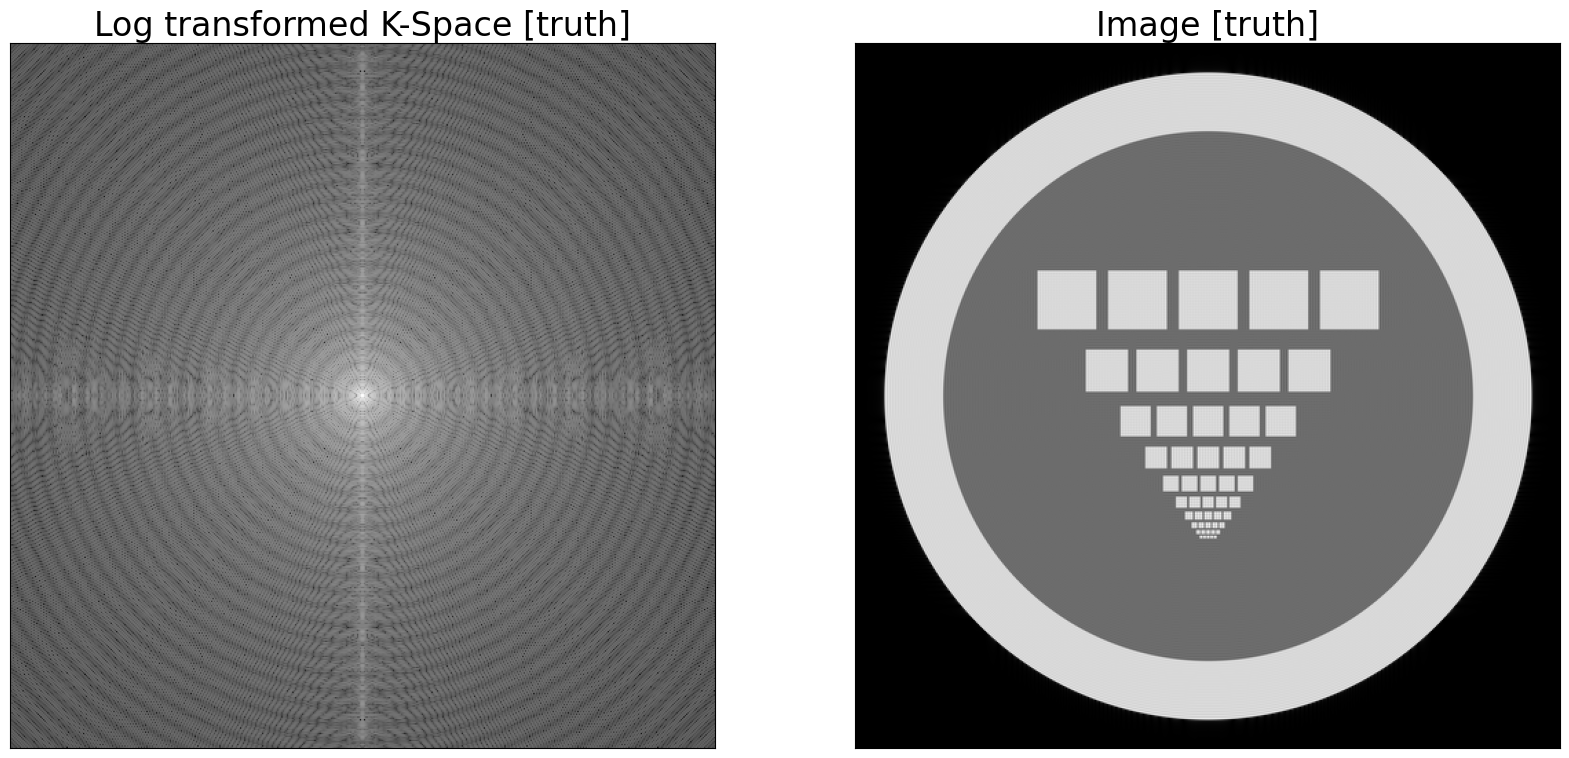

In [54]:
def k_shift(k, kx, ky,x_shift, y_shift):
  '''
    Shift a k-space signal by adding linear phase
  '''
  return k*np.exp(2j*math.pi*ky*y_shift)*np.exp(2j*math.pi*kx*x_shift)

def k_square( kx, ky, x_shift, y_shift, w):
  '''
    Fourier transform of a square is sinc(kx)*sinc(ky)
  '''
  k =np.sinc(kx*w)*np.sinc(ky*w)*w*w
  return( k_shift(k, kx,ky,x_shift, y_shift))

def k_circle( kx, ky, x_shift, y_shift, w):
  '''
    Fourier transform of a circle is bessel function
  '''
  kr = w*np.sqrt(kx**2 + ky**2)
  k = scipy.special.jv(1., kr * 2.0 * math.pi ) / (1e-6 + kr) * w**2
  return( k_shift(k, kx,ky,x_shift, y_shift))

def bullseye_phantom( kx, ky, kt=None):
  '''
    Function to create a bullseye phantom

    Input:
      kx:   k-space coordinates in kx [1/m]
      ky:   k-space coordinates in ky [1/m]
      kt:   time of each sample [s]
    Output:
      k_total:  complex k-space at kx,ky,t
  '''
  # Central water
  k_water = np.zeros_like( kx, dtype=np.complex64)
  k_water += k_circle(kx, ky, 0.0, 0.0, 90e-3)

  # Some small squares
  widths = np.geomspace(1e-3,20e-3,10)
  shifts = 1.2*(np.cumsum(widths) - 0.6*np.sum(widths))
  for position_y, w in zip(shifts, widths):
    stride = 1.2*w
    for position_x in [-2,-1,0,1,2]:
      k_water += k_square(kx, ky, stride*position_x, position_y, w)

  # Outer fat
  k_fat =  k_circle(kx, ky, 0.0, 0.0, 110e-3) - k_circle(kx, ky, 0.0, 0.0, 90e-3)

  if kt is not None:
    k_fat *= np.exp(2j*math.pi*440*kt)

  k_total = k_water + 2*k_fat

  return k_total


# Defined size for phantom
FOV = 0.240 # m
dK = 1/FOV # m^-1
N = 512
kmax = N/2*dK

# Evaluate k-space
[kx, ky] = np.meshgrid( np.linspace(-kmax,kmax,N, dtype=np.float32),  np.linspace(-kmax,kmax,N, dtype=np.float32))
k = bullseye_phantom(kx,ky)

# Reconstruct with FFT
image = np.fft.fftshift(np.fft.ifft2(k))

# Plot
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(np.log(np.abs(k)), cmap='gray')
plt.xticks([], [])
plt.yticks([], [])
plt.title('Log transformed K-Space [truth]')
plt.subplot(122)
plt.imshow(np.abs(image), cmap='gray')
plt.title('Image [truth]')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

# Creating a 2D sampling

This sets up a sampling experiment very similar to how a scanner would. There are two system constraints in the code whcih we haven't discussed:
* $G_{max}$ the maximum gradient strength. Typically 20-80 mT/m
* $slew$ $rate$ the maximum rate the gradient can change, typically 80-200 T/m/s

These are hardcoded below to $50 mT/m$ and $100 T/m/s$ but feel free to change them to see their influence. They are below:
```
  gmax_system = 50e-3 # mT/m
  slew_system = 100 # T/m/s
```

## Readout Parameters
There are a couple of ways to define sampling but we will define  based on:
* $BW [Hz]$ : the is effectively the strength of the frequency encoding gradient. We are using the definition $BW=\gamma G_{freq} FOV$ where $FOV$ is the defined field-of-view in x. This $FOV$ is just a convention but will define the size of the reconstructed image in the frequency encoding direction.
* $k_{max} [1/m]$ in x and y. The is the maximum area of the gradient.
* $\Delta k_y $ the spacing of phase encodes. This also sets the number of phase encodes $ N_{pe} = \frac{2 k_{max} }{ \Delta k_y } $

## Experiments to try:
* Change the $BW$, what happens to the sampling time and gradient strength? When might you use a high $BW$ vs. a low $BW$ ?
* What parameters change the echo time?
* Which parameters have the largest effect on scan time?
* Why do we not have a $\Delta k_x $?


In [55]:
def build_prephaser( area, slew, gmax, dT):
  """
    Function to estimate gradient based on area.

    Input:
      area  - area of gradient in s*T/m
      slew  - slew rate of system in T/m/s
      gmax  - maximum gradient strength of system
      dT    - resolution of gradient system

    Output:
      g_trap - the gradient in T/m in the resolution of the system
  """

  # This will help with some of the math
  t_rise = (gmax/slew)
  area_min_trap = t_rise * gmax

  if np.abs(area) < area_min_trap:
    # Triangle shaped gradient
    pwa = np.sqrt( np.abs(area) / slew )
    pw = 0
  else:
    # Trapezoid shaped gradient
    pwa = t_rise
    pw = (np.abs(area) - area_min_trap ) / gmax

  # Round to system resolution
  n_pw = int(np.round(pw/dT))
  n_pwa = int(np.round(pwa/dT))

  # Add the attack, flattop, decay
  g_trap = np.concatenate((np.linspace(0,1,n_pwa), np.ones((n_pw,)), np.linspace(1,0,n_pwa)))
  g_trap = g_trap * area / (dT*np.sum(g_trap))

  return g_trap

def build_readout(BW, FOV, kmax, slew, gmax, dT, gamma=42.58e6):
  """
    Function to estimate gradient for a readout

    Input:
      BW    - Bandwidth of readout in Hz
      FOV   - Field of view in m
      kmax  - Maximum extent in k-space in 1/m
      slew  - slew rate of system in T/m/s
      gmax  - maximum gradient strength of system
      dT    - resolution of gradient system

    Output:
      g_trap - the gradient in T/m in the resolution of the system
      pre_phase_area - the area required to phase the gradients
      idx - index array for readout
  """

  # BW is in +/- Hz over the FOV (solve BW = gamma*G*FOV)
  amp_freq = BW / (gamma*FOV)

  # Get the central area where we sample
  area = 2.0*kmax / gamma
  Tread = area / amp_freq
  n_pw = int(np.round(Tread/dT))

  # Get Prephase
  Tramp = amp_freq / slew
  n_pwa = int(np.round(Tramp/dT))

  g_trap = np.concatenate((np.linspace(0,1,n_pwa), np.ones((n_pw,)), np.linspace(1,0,n_pwa)))
  g_trap *= amp_freq

  idx = np.concatenate((np.zeros(n_pwa,), np.ones((n_pw,)), np.zeros(n_pwa,)))
  idx = idx == 1

  pre_phase_area = -0.5*Tramp*amp_freq - 0.5*Tread*amp_freq

  return g_trap, pre_phase_area, idx

def calc_2d_gradients( BW, kmax_x, kmax_y):
  """
    Function to estimate gradient for a readout with phase encoding

    Input:
      BW     - Bandwidth of readout in Hz
      kmax_x - Maximum extent in x [1/m]
      kmax_y - Maximum extent in y [1/m]
    Output:
      gx, gy - the gradient in mT/m in the resolution of the system
  """

  # System paramaters (fixed in this simulation)
  FOV = 0.24 # m
  gmax_system = 50e-3 # mT/m
  slew_system = 100 # T/m/s
  gamma = 42.58e6
  dT_system = 4e-6

  # Build the gradients. This uses system limits
  gx_read, pre_phase_area, idx = build_readout(BW=BW,FOV=FOV, kmax=kmax_x, slew=slew_system, gmax=gmax_system, dT=dT_system)
  gx_pre = build_prephaser( pre_phase_area, slew=slew_system, gmax=gmax_system, dT=dT_system)
  gy_pre = build_prephaser( kmax_y / gamma, slew=slew_system, gmax=gmax_system, dT=dT_system)

  # Pad prephaser so that the pulses are the same length
  if len(gx_pre) > len(gy_pre):
    # Pad gy with zeros
    gy_pre = np.pad(gy_pre,(0,len(gx_pre)-len(gy_pre)))
  elif len(gx_pre) < len(gy_pre):
    # Pad x=gx with zeros
    gx_pre = np.pad(gx_pre,(len(gy_pre)-len(gx_pre),0))

  gx = np.concatenate((gx_pre,gx_read))
  gy = np.concatenate((gy_pre,0*gx_read))

  idx = np.concatenate((np.zeros((len(gx_pre,))), idx))
  idx = idx == 1.0

  # Convert to k-space
  kx = gamma*np.cumsum(gx)*dT_system
  ky = gamma*np.cumsum(gy)*dT_system
  kt = dT_system*np.arange(len(kx))

  return gx, gy, kx, ky, kt, idx

def plot_gradient( BW, kmax_x, kmax_y, dk_y):

  # Calculate the gradients for the largest phase encode
  gx, gy, kx, ky, kt, idx = calc_2d_gradients( BW, kmax_x, kmax_y)

  # Scale gy for
  Npe = int( (2*kmax_y / dk_y) + 1)
  ky_scale = np.linspace(-1,1,Npe)

  plt.figure(figsize=(8,8))

  # Plot Gx
  plt.subplot(221)
  plt.plot(1e3*kt,1e3*gx)
  plt.ylabel('$G_x$ [mT/m]')
  plt.xlabel('$Time$ [us]')
  plt.ylim([-50, 50])

  # Plot Gy
  plt.subplot(223)
  for scale in ky_scale:
    plt.plot(1e3*kt,1e3*gy*scale)
  plt.ylabel('$G_y$ [mT/m]')
  plt.xlabel('$Time$ [ms]')
  plt.ylim([-50, 50])

  # Plot Kx
  plt.subplot(222)
  plt.plot(1e3*kt,kx/1e3)
  plt.ylabel('$K_x$ [1/mm]')
  plt.xlabel('$Time$ [ms]')

  # Plot Ky
  plt.subplot(224)
  for scale in ky_scale:
    plt.plot(1e3*kt,ky*scale/1e3)
  plt.ylabel('$K_y$ [1/mm]')
  plt.xlabel('$Time$ [ms]')

  plt.tight_layout(pad=2)
  plt.show()


w = interactive(plot_gradient,
                BW=FloatSlider(min=62.5e3, max=250e3, value=125e3, description='BW [Hz]', continuous_update=False),
                kmax_x=FloatSlider(min=1/20e-3, max=1/1e-3, value=1/2e-3, step=1, description='Kmax x [1/m]', continuous_update=False),
                kmax_y=FloatSlider(min=1/20e-3, max=1/1e-3, value=1/2e-3, step=1, description='Kmax y [1/m]', continuous_update=False),
                dk_y=FloatSlider(min=1/240e-3, max=1/10e-3, value=1/10e-3, description='dky [1/m]', continuous_update=False))

display(w)

interactive(children=(FloatSlider(value=125000.0, continuous_update=False, description='BW [Hz]', max=250000.0…

# Imaging Experiment

This will simulate and plot images for the given phantom and parameters. You can alway reset the parameters by rerunning the cell. Some of the parameters will cause the cell to run for several seconds before it updates. Some experiments to try:

1.   Starting with the default parameters, change the BW higher and lower. What are the effects and which bandwidth would you choose based on this experiment?
2.   Repeat 1 but with higher noise levels. Does this change your answer to 1?
3.   Increase the $\Delta k_y$. Do the artifacts look as you would expect?
4.   With no noise, change the $k_{max}$. Are there artifacts aside from the resolution differences?
5.   Repeat 4 with noise.
6.   With high noise levels, increase the number of averages. What is the effect?


In [56]:
def get_kspace_coordinates( BW, kmax_x, kmax_y, dk_y):
  """
    Function to get k-space coordinates

    Input:
      BW:     - Bandwidth of readout in Hz
      kmax_x: - Maximum extent in x [1/m]
      kmax_y: - Maximum extent in y [1/m]
      dk_y:   - The spacing of ky phase encodes [1/m]
    Output:
      kx:     - kx coordinates [1/m]
      ky:     - kt coordinates [1/m]
      kt:     - kt sampling time of each point in kspace

  """

  # Calculate the gradients for the largest phase encode
  gx, gy, kx, ky, kt, idx = calc_2d_gradients( BW, kmax_x, kmax_y)

  # Scale gy for each phase encode
  Npe = int( (2*kmax_y / dk_y) + 1)
  ky_scale = np.linspace(-1,1,Npe)

  # gather kx,ky for all the phase encodes
  kx_2 = []
  ky_2 = []
  kt_2 = []
  for scale in ky_scale:
    kx_2.append(kx[idx])
    ky_2.append(scale*ky[idx])
    kt_2.append(kt[idx])
  kx = np.stack(kx_2,axis=0)
  ky = np.stack(ky_2,axis=0)
  kt = np.stack(kt_2,axis=0)

  return kx, ky, kt

def sim_and_plot( BW=250e3, kmax_x=1/10e-3, kmax_y=1/10e-3, dk_y=1/240e-3, noise=0, averages=1):

  # Get y
  kx, ky, kt = get_kspace_coordinates( BW=BW, kmax_x=kmax_x, kmax_y=kmax_y, dk_y=dk_y)

  # Get kspace values
  k0 = bullseye_phantom(0,0)

  # Add noise
  kspace = averages*bullseye_phantom(kx, ky, kt)
  for a in range(averages):
    kspace += k0*noise*(np.random.standard_normal(kspace.shape) + 1j*np.random.standard_normal(kspace.shape))

  # Reconstruct with Fourier transform
  image = np.fft.fftshift(np.fft.ifft2(kspace))

  # For plotting the image size will change based on BW. Adjust to suite
  BW_system = 1 / (kt[0,1] - kt[0,0])
  aspect = BW_system / BW
  crop = np.abs(np.linspace(-aspect, aspect, image.shape[1])) < 1.0

  # Also adjust y fov to match reconstructed size
  aspect_y = 1/240e-3  / dk_y

  print(f'Minimum scan time = {np.max(kt)*ky.shape[0]*averages}, Echo time = {1e3*np.mean(kt)} ms')

  plt.figure(figsize=(10,10))
  plt.imshow(np.abs(image[:,crop]),aspect=aspect_y,cmap='gray')
  plt.xticks([], [])
  plt.yticks([], [])
  plt.show()

w = interactive(sim_and_plot,
                BW=FloatSlider(min=62.5e3, max=250e3, value=125e3, description='BW [Hz]', continuous_update=False),
                kmax_x=FloatSlider(min=1/20e-3, max=1/1e-3, value=1/2e-3, step=1, description='Kmax x [1/m]', continuous_update=False),
                kmax_y=FloatSlider(min=1/20e-3, max=1/1e-3, value=1/2e-3, step=1, description='Kmax y [1/m]', continuous_update=False),
                dk_y=FloatSlider(min=1/240e-3, max=1/80e-3, value=1/480e-3, step=1/480e-3, description='dky [1/m]', continuous_update=False),
                noise=FloatSlider(min=0, max=0.1, value=0, step=1e-6, description='noise level', continuous_update=False),
                averages=IntSlider(min=1, max=4, value=1, description='averages', continuous_update=False))

display(w)

interactive(children=(FloatSlider(value=125000.0, continuous_update=False, description='BW [Hz]', max=250000.0…